# Usage of multiple wallets via statistical risk managment


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
from pathlib import Path

# setup path to project root
sys.path.append(str(Path.cwd().parent))

In [2]:
from typing import Dict, Any, Optional
from pathlib import Path
import logging
import random

import numpy as np
import yaml

try:
    import torch
except ImportError:  # pragma: no cover - optional dependency
    torch = None

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger("erc_notebook")


def load_config(path: Optional[Path] = None) -> Dict[str, Any]:
    if path is None:
        path = Path(__file__).with_name("config.yaml")
    with path.open("r", encoding="utf-8") as f:
        return yaml.safe_load(f)



def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    if torch is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)


config_path = Path('../pipelines/portfolio_erc_static/config.yaml').resolve().absolute()
config = load_config(Path(config_path) if config_path else None)

seed = int(config.get("seed", 42))
set_global_seed(seed)


INFO:pipelines.portfolio_erc_static.data_loader:Fetching LINK/USDT from Binance (d)


INFO:pipelines.portfolio_erc_static.data_loader:Fetching SOL/USDT from Binance (d)


INFO:pipelines.portfolio_erc_static.data_loader:Fetching XRP/USDT from Binance (d)


INFO:pipelines.portfolio_erc_static.data_loader:Fetching BNB/USDT from Binance (d)


INFO:pipelines.portfolio_erc_static.data_loader:Fetching ADA/USDT from Binance (d)


INFO:pipelines.portfolio_erc_static.data_loader:Fetching DOT/USDT from Binance (d)


<Axes: xlabel='date'>

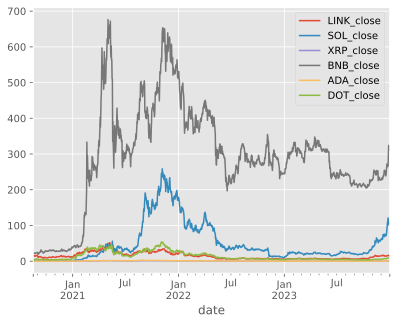

In [3]:
from pipelines.portfolio_erc_static.data_loader import load_price_panel

data_cfg = config["data"]
symbols = data_cfg["symbols"]
data = load_price_panel(data_cfg)

data[[f'{symbol}_close' for symbol in symbols]].plot()

In [4]:
portfolio_section = config.get("portfolio", {})

warm_start = int(portfolio_section.get("warm_start_days", 60))
validation_duration = data_cfg.get("validation_duration_days")
if validation_duration is not None:
    validation_days = max(int(validation_duration), 0)
    total_required = warm_start + validation_days
    if total_required <= warm_start:
        total_required = warm_start + 1
        LOGGER.warning(
            "Validation window %d adjusted to ensure at least one trading day",
            validation_days,
        )
    if total_required < len(data):
        data = data.tail(total_required)
        LOGGER.info(
            "Restricting dataset to last %d rows (warm-up %d + validation %d)",
            len(data),
            warm_start,
            validation_days,
        )
    elif total_required > len(data):
        LOGGER.warning(
            "Requested validation window (%d) exceeds dataset length %d; using full history",
            total_required,
            len(data),
        )


INFO:erc_notebook:Restricting dataset to last 465 rows (warm-up 100 + validation 365)


In [5]:
import tensortrade.env.default as default_env
from tensortrade.env.default import renderers as renderer_module
from tensortrade.env.default import rewards as reward_api
from tensortrade.env.default.renderers import construct_renderers
from tensortrade.feed.core import DataFeed, NameSpace, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.instruments import Instrument, registry
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Portfolio, Wallet

In [6]:
from pipelines.portfolio_erc_static.action_scheme import ScheduledOrdersActionScheme
from pathlib import Path
from typing import Dict, List, Optional, Tuple, TypedDict
import numpy as np
import pandas as pd

def build_environment(
    data: pd.DataFrame, config: Dict, portfolio_cfg: Dict
) -> Tuple[default_env.TradingEnv, List[str]]:
    symbols = portfolio_cfg["symbols"]
    base_symbol = portfolio_cfg.get("base_symbol", portfolio_cfg.get("main_currency", "USDT"))

    if base_symbol not in registry:
        registry[base_symbol] = Instrument(base_symbol, 2, base_symbol)
    base_instrument = registry[base_symbol]

    for sym in symbols:
        if sym not in registry:
            registry[sym] = Instrument(sym, 8, sym)

    price_streams = [
        Stream.source(list(data[f"{sym}_close"]), dtype="float").rename(f"{base_symbol}-{sym}")
        for sym in symbols
    ]

    exchange_name = config.get("exchange", "simulator")
    exchange = Exchange(exchange_name, service=execute_order, options=ExchangeOptions(commission=0.0))(*price_streams)

    initial_cash = float(portfolio_cfg.get("initial_cash", 0.0))
    cash_wallet = Wallet(exchange, initial_cash * base_instrument)
    asset_wallets = [Wallet(exchange, 0 * registry[sym]) for sym in symbols]
    portfolio = Portfolio(base_instrument, [cash_wallet, *asset_wallets])

    timestamp_values = (data.index.view("int64") // 10**9).astype(float)
    feature_columns = ["timestamp", *list(data.columns)]

    with NameSpace(exchange_name):
        feature_streams = [
            Stream.source(list(timestamp_values), dtype="float").rename("timestamp"),
            *[
                Stream.source(list(data[column]), dtype="float").rename(column)
                for column in data.columns
            ],
        ]

    feed = DataFeed(feature_streams)
    feed.compile()

    renderer_streams: List[Stream] = []
    renderer_streams.append(Stream.source(list(data.index.astype(str)), dtype="str").rename("date"))
    for sym in symbols:
        for field in ["open", "high", "low", "close", "volume"]:
            column = f"{sym}_{field}"
            if column in data.columns:
                renderer_streams.append(Stream.source(list(data[column]), dtype="float").rename(column))
    renderer_feed = DataFeed(renderer_streams)
    renderer_feed.compile()

    renderer_cfg = config.get("renderer", "all")
    if renderer_cfg == "all":
        renderer_cfg = [
            name for name in renderer_module._registry.keys() if name != "screen-log"
        ]
    renderer_formats = config.get("renderer_formats", ["png", "html"])
    renderers = construct_renderers(
        renderer_cfg, display=False, save_formats=renderer_formats
    )

    action_scheme = ScheduledOrdersActionScheme(portfolio)
    reward_scheme = reward_api.get(config.get("reward_scheme", "simple"))

    env = default_env.create(
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        feed=feed,
        renderer_feed=renderer_feed,
        window_size=int(config.get("window_size", 1)),
        enable_logger=False,
        renderer=renderers,
    )
    return env, feature_columns


portfolio_cfg = {
    "symbols": symbols,
    "base_symbol": data_cfg.get("main_currency", "USDT"),
    "initial_cash": portfolio_section.get("initial_cash", 1_000_000),
}

env, feature_columns = build_environment(
    data, config.get("environment", {}), portfolio_cfg
)

Constructing renderers: type(identifier)=<class 'list'>


In [7]:
from pipelines.portfolio_erc_static.action_scheme import ScheduledOrdersActionScheme
from pipelines.portfolio_erc_static.covariance import LedoitWolfConfig, LedoitWolfShrinkage
from pipelines.portfolio_erc_static.data_loader import load_price_panel
from pipelines.portfolio_erc_static.erc_solver import ERCSolver, ERCSolverConfig
from pipelines.portfolio_erc_static.rebalancer import ExecutionConfig, PortfolioRebalancer
from pipelines.portfolio_erc_static.scheduler import RebalanceScheduler

In [8]:
def to_mapping(value) -> Dict[str, float]:
    if value is None:
        return {}
    if isinstance(value, dict):
        return {str(k): float(v) for k, v in value.items()}
    return {"default": float(value)}


action_scheme: ScheduledOrdersActionScheme = env.action_scheme  # type: ignore[assignment]
portfolio = action_scheme.portfolio

close_prices = data[[f"{sym}_close" for sym in symbols]]
returns = close_prices.pct_change().dropna()

scheduler = RebalanceScheduler(
    warm_start_days=warm_start,
    rebalance_period_days=int(portfolio_section.get("rebalance_period_days", 30)),
    enable_online_rebalance=bool(
        portfolio_section.get("enable_online_rebalance", True)
    ),
)

cov_cfg = portfolio_section.get("covariance", {})
estimator = LedoitWolfShrinkage(
    LedoitWolfConfig(
        window=int(cov_cfg.get("window", warm_start)),
        min_history=int(cov_cfg.get("min_history", warm_start)),
    )
)

erc_cfg = portfolio_section.get("erc", {})
solver = ERCSolver(
    ERCSolverConfig(
        tolerance=float(erc_cfg.get("tolerance", 1e-5)),
        max_iterations=int(erc_cfg.get("max_iterations", 500)),
        min_weight=float(erc_cfg.get("w_min", 0.0)),
        max_weight=float(erc_cfg.get("w_max", 1.0)),
    )
)

exec_cfg = ExecutionConfig(
    base_symbol=portfolio_cfg["base_symbol"],
    symbols=symbols,
    commission_buy=float(portfolio_section.get("commission_buy", 0.0)),
    commission_sell=float(portfolio_section.get("commission_sell", 0.0)),
    slippage_bps=float(portfolio_section.get("slippage_bps", 0.0)),
    delta=to_mapping(portfolio_section.get("delta", 0.0)),
    lot_size=to_mapping(portfolio_section.get("lot_size")),
    tick_size=to_mapping(portfolio_section.get("tick_size")),
)
rebalancer = PortfolioRebalancer(exec_cfg)

In [9]:
class PendingTarget(TypedDict):
    weights: np.ndarray
    close_prices: pd.Series



def parse_observation(obs: np.ndarray) -> Tuple[pd.Timestamp, pd.Series]:
    array = np.asarray(obs)
    if array.ndim == 2 and array.shape[0] > 0:
        row = array[-1]
    else:
        row = array
    if row.shape[0] != len(feature_columns):
        raise ValueError("Observation width does not match feature columns")
    series = pd.Series(row, index=feature_columns, dtype=float)
    timestamp = pd.to_datetime(series["timestamp"], unit="s", utc=True)
    prices = series.drop(labels=["timestamp"])
    return timestamp, prices



def create_orders_for_pending_target(
    rebalancer: PortfolioRebalancer,
    portfolio: Portfolio,
    target: Optional[PendingTarget],
    execution_prices: pd.Series,
) -> Tuple[List, Optional[PendingTarget]]:
    if target is None:
        return [], None
    orders = rebalancer.compute_orders(
        portfolio,
        target["close_prices"],
        execution_prices,
        target["weights"],
    )
    return orders, None



def interpret_step_output(step_result) -> Tuple[np.ndarray, float, bool, bool, Dict]:
    """Normalise environment.step outputs across Gym/Gymnasium variants."""

    if not isinstance(step_result, tuple):
        raise TypeError(
            "TradingEnv.step is expected to return a tuple of results, "
            f"received {type(step_result)!r}"
        )

    length = len(step_result)
    if length == 5:
        state, reward, terminated, truncated, info = step_result
        return state, float(reward), bool(terminated), bool(truncated), info
    if length == 4:
        state, reward, done, info = step_result
        terminated = bool(done)
        truncated = False
        return state, float(reward), terminated, truncated, info

    raise ValueError(
        "TradingEnv.step returned an unexpected number of values "
        f"({length}); expected 4 or 5"
    )



def get_portfolio_weights(
    portfolio: Portfolio, symbols: List[str], prices: pd.Series
) -> np.ndarray:
    exchange = portfolio.exchange_pairs[0].exchange
    base_symbol = portfolio.base_instrument.symbol
    cash_wallet = portfolio.get_wallet(exchange.id, registry[base_symbol])
    cash_balance = float(cash_wallet.balance.as_float())

    asset_values = np.zeros(len(symbols), dtype=float)
    for i, sym in enumerate(symbols):
        wallet = portfolio.get_wallet(exchange.id, registry[sym])
        quantity = float(wallet.balance.as_float())
        price = float(prices[f"{sym}_close"])
        asset_values[i] = quantity * price

    net_worth = cash_balance + float(asset_values.sum())
    weights = np.zeros(len(symbols), dtype=float)
    if net_worth > 0:
        weights = asset_values / net_worth
    return weights


In [10]:
state, info = env.reset(begin_from_start=True)

pending_target: Optional[PendingTarget] = None
target_history: List[Dict] = []

current_date, current_prices = parse_observation(state)

step_index = 0
done = False

while not done:

    orders_today, pending_target = create_orders_for_pending_target(
        rebalancer,
        portfolio,
        pending_target,
        current_prices,
    )

    if orders_today:
        action_scheme.schedule(orders_today)
    else:
        action_scheme.clear()

    step_state, reward, terminated, truncated, _ = interpret_step_output(
        env.step(0, skip_decision=not bool(orders_today))
    )
    state = step_state
    done = bool(terminated or truncated)

    current_weights = get_portfolio_weights(portfolio, symbols, current_prices)

    if not done and scheduler.should_rebalance(step_index):
        window_returns = returns.loc[:current_date].tail(estimator.config.window)
        try:
            cov_matrix, shrinkage = estimator.estimate(window_returns)
        except ValueError as err:
            LOGGER.warning(
                "Covariance estimation failed at %s: %s", current_date, err
            )
            cov_matrix = None
        if cov_matrix is not None:
            try:
                weights, diag = solver.solve(
                    cov_matrix, initial_weights=current_weights
                )
            except ValueError as err:
                LOGGER.warning("ERC solver failed at %s: %s", current_date, err)
            else:
                pending_target = PendingTarget(
                    weights=weights,
                    close_prices=current_prices.copy(),
                )
                target_history.append(
                    {
                        "date": current_date.isoformat(),
                        "weights": {
                            sym: float(weights[i]) for i, sym in enumerate(symbols)
                        },
                        "shrinkage": float(shrinkage),
                        "portfolio_variance": float(
                            diag.get("portfolio_variance", 0.0)
                        ),
                        "max_error": float(diag.get("max_error", 0.0)),
                    }
                )

    if done:
        break

    step_index += 1
    current_date, current_prices = parse_observation(state)


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9985 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


INFO:pipelines.portfolio_erc_static.rebalancer:Scaling buy orders by 0.9970 to respect budget


In [11]:
env.render()